In [10]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
import sys, os
import seaborn as sns


/Users/ischaider/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


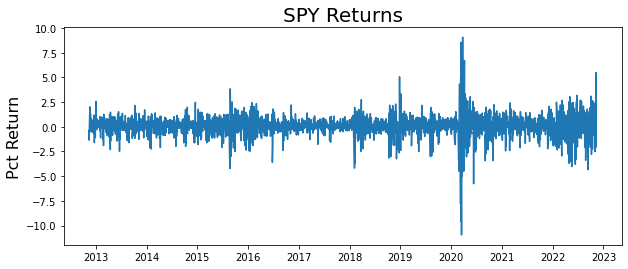

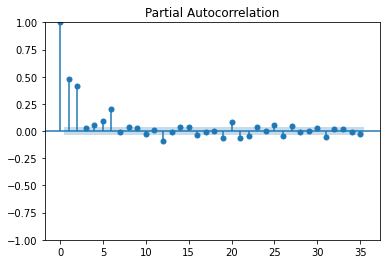

In [2]:
start = datetime(2012, 11, 11)
end = datetime(2022, 11, 11)
spy = web.DataReader('SPY', 'yahoo', start=start, end=end)
returns = 100 * spy.Close.pct_change().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SPY Returns', fontsize=20)
plot_pacf(returns**2)
plt.show()

In [3]:
temp_stdout = None

# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout

In [44]:
def get_opt_model(returns, max_p, max_q):
    min_aic = float('inf')
    opt_p_q = []
    aic_mat = np.zeros((max_p, max_q))
    for p in range(1, max_p+1):
        for q in range(1, max_p+1):
            model = arch_model(returns, p=p, q=q)
            model_fit = model.fit()
            aic = model_fit.aic
            aic_mat[p-1, q-1] = round(aic, 1)
            if aic < min_aic:
                min_aic = aic
                opt_p_q = [p, q]
    return opt_p_q[0], opt_p_q[1], aic_mat

In [39]:
def heatmap(mat, model_type, metric):
    plt.clf()
    heatmap = sns.heatmap(mat, 
                            # cmap=color_scheme,
                            xticklabels=range(1, mat.shape[0]+1),
                            yticklabels=range(1, mat.shape[0]+1), 
                            vmin=np.min(mat), 
                            vmax=np.max(mat))
    heatmap.set_title(f"{metric} Heatmap")
    heatmap.set(xlabel = f"{model_type} q values", ylabel = "GARCH p values")
    plt.show()

In [40]:
def rolling_predictions(returns, opt_p, opt_q):
    warnings.filterwarnings('ignore')
    rolling_predictions = []
    test_size = 365*5

    for i in range(test_size):
        train = returns[:-(test_size-i)]
        model = arch_model(train, p=opt_p, q=opt_q)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        
    rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*5:])

    plt.figure(figsize=(10,4))
    true, = plt.plot(returns[-365*5:])
    preds, = plt.plot(rolling_predictions)
    plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
    plt.legend(['Returns', 'Predicted Volatility'], fontsize=16)

In [45]:
def train_metrics(returns, model_type, metric, max_p, max_q):
    blockPrint()
    opt_p, opt_q, aic_mat = get_opt_model(returns, max_p, max_q)
    opt_model = arch_model(returns, p=opt_p, q=opt_q, vol=model_type).fit()
    enablePrint()
    
    print(f"{metric} matrix: \n{aic_mat}")
    heatmap(aic_mat, model_type, metric)

    print(f"\n--- {model_type}({opt_p}, {opt_q}) ---")
    print(opt_model.summary())
    
    rolling_predictions(returns, opt_p, opt_q)

AIC matrix: 
[[6261.5 6263.5 6265.5 6267.5 6269.5]
 [6263.2 6264.3 6266.3 6268.3 6270.3]
 [6264.4 6266.4 6267.4 6269.4 6270.6]
 [6266.4 6265.4 6267.  6268.8 6268.1]
 [6268.4 6267.4 6269.  6270.8 6270.1]]


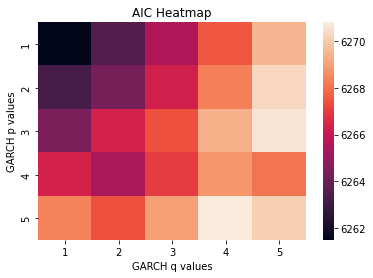


--- GARCH(1, 1) ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3126.76
Distribution:                  Normal   AIC:                           6261.52
Method:            Maximum Likelihood   BIC:                           6284.84
                                        No. Observations:                 2518
Date:                Tue, Dec 06 2022   Df Residuals:                     2517
Time:                        17:03:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.399e-02      6.111

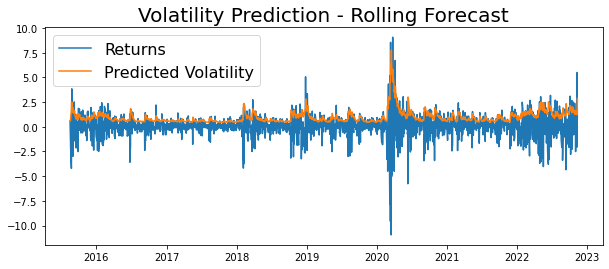

In [46]:
train_metrics(returns=returns, model_type="GARCH", metric="AIC", max_p=5, max_q=5)